# Task 1 ：复现实验

分析文章的baseline，发现该方法无法在真实场景中使用：
1. 选取的数据集中，有异常数据
2. 选取的特征中，有无效特征
3. 通过特征图筛选，可以筛选出3～4个特征，使用筛选出来的特征，可达到与全部特征相近的结果
4. 选取的特征，为不稳定特征，无法在真实场景中使用

In [24]:
import os,sys
sys.path.append("./share")
sys.path.append("./common")
from Config import g_data_root
import pandas as pd
import numpy as np
import warnings,logging,re
from SHVisualize import CSHVisualize
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
from datetime import datetime
from SHModelClassify import CSHModelClassify
from SHEvaluation import CSHROC
from SHSample import CSHSample
from SHDataProcess import CSHDataProcess
from SHDataEDA import CSHDataDistribution,CSHDataTest
from SHFeatureSelect import CSHFeature
import h2o
from pyecharts.globals import CurrentConfig, NotebookType
CurrentConfig.NOTEBOOK_TYPE = NotebookType.JUPYTER_LAB
tqdm.pandas()
import warnings
warnings.simplefilter(action='ignore')
h2o.init(nthreads = -1, verbose=False)

# 定义公共函数

In [6]:
def is_valid_ip(ip_str):
    ip_pattern = re.compile(r'^((25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.){3}(25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)$')
    if ip_pattern.match(ip_str):
        octets = ip_str.split('.')
        for octet in octets:
            if int(octet) > 255:
                return False
        return True
    else:
        return False

def is_valid_time(time_str):
    tmp = time_str.strip()
    tmp = tmp[:-3]
    try:
        datetime.strptime(tmp, '%Y %H:%M:%S.%f')
        return True
    except ValueError:
        return False

In [7]:
df = pd.read_csv("%s/raw/Selected dataset for ML and DL/ML-EdgeIIoT-dataset.csv"%g_data_root,low_memory=False)

# 过滤掉异常数据
1. 时间格式错误
2. ip地址错误

In [8]:
def pre_process(x):
    ret = "ok"
    if not is_valid_time(x['frame.time']):
        ret = "frame.time"
    elif not is_valid_ip(x['ip.src_host']) and not is_valid_ip(x['arp.src.proto_ipv4']):
        ret = "src_host"
    elif not is_valid_ip(x['ip.dst_host']) and not is_valid_ip(x['arp.dst.proto_ipv4']):
        ret = "dst_host"
    return ret
    
df['flag'] = df.progress_apply(pre_process,axis=1)
df = df[df['flag'] == "ok"]

del df['frame.time']
del df['ip.src_host']
del df['ip.dst_host']
del df['arp.src.proto_ipv4']
del df['arp.dst.proto_ipv4']
del df['tcp.srcport']
del df['tcp.dstport']
del df['udp.port']
del df['tcp.payload']
del df['http.tls_port']
del df['http.file_data']
del df['icmp.transmit_timestamp']
del df['http.request.uri.query']
del df['http.referer']
del df['http.request.full_uri']
del df['http.request.version']
del df['tcp.options']
del df['dns.qry.name.len']
del df['mqtt.msg']

one_hot_encoded = pd.get_dummies(df['http.request.method'],prefix='http.request.method')
df = pd.concat([df, one_hot_encoded], axis=1)
#one_hot_encoded = pd.get_dummies(df['mqtt.conack.flags'],prefix='mqtt.conack.flags')
#df = pd.concat([df, one_hot_encoded], axis=1)
#one_hot_encoded = pd.get_dummies(df['mqtt.protoname'],prefix='mqtt.protoname')
#df = pd.concat([df, one_hot_encoded], axis=1)
#one_hot_encoded = pd.get_dummies(df['mqtt.topic'],prefix='mqtt.topic')
#df = pd.concat([df, one_hot_encoded], axis=1)

del df['http.request.method']
del df['mqtt.conack.flags']
del df['mqtt.protoname']
del df['mqtt.topic']
df['Attack_type']=df['Attack_type'].astype(dtype='category')
df['Attack_code']=df['Attack_type'].cat.codes

  0%|          | 0/157800 [00:00<?, ?it/s]

# 发现异常特征
1. mqtt.conack.flags
2. mqtt.protoname
3. mqtt.topic

In [9]:
#mqtt.conack.flags_0',
#'mqtt.conack.flags_0.0',
#'mqtt.conack.flags_0x00000000'
#df_tmp = df[['http.request.method','mqtt.protoname','mqtt.topic','mqtt.conack.flags','Attack_label']]
#df_tmp=df_tmp[df_tmp['Attack_label'] == 1]
#df_tmp['mqtt.topic'].unique()

# 选取base的特征
1. 去掉冗余字段
2. 设置特征字段和标签字段
3. 去掉只有唯一值的特征

In [10]:
df_base = df.copy(deep=True)
del df_base['Attack_type']
del df_base['flag']
del df_base['Attack_code']

#for col in df_base.columns.tolist():
#    if col in ['tcp.ack','tcp.flags','tcp.connection.rst','http.request.method_0.0','tcp.ack_raw','http.request.method_0']:
#        del df_base[col]
        
for key in df_base.columns:
    if df_base[key].nunique() <= 1:
        del df_base[key]

col_y = "Attack_label"
col_x = []
for col in df_base.columns.tolist():
    if not col == col_y:
        col_x.append(col)

# 进行SMOTE采样

In [11]:
df_tmp = CSHSample.resample_smote(df_base,x_columns=col_x,y_column=col_y) 

# 对特征字段进行标准化处理

In [12]:
df_data, scale_columns = CSHDataProcess.get_scale(df_tmp,y_column=col_y)

# 查看信息图

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
infogram Model Build progress: |█████████████████████████████████████████████████| (done) 100%


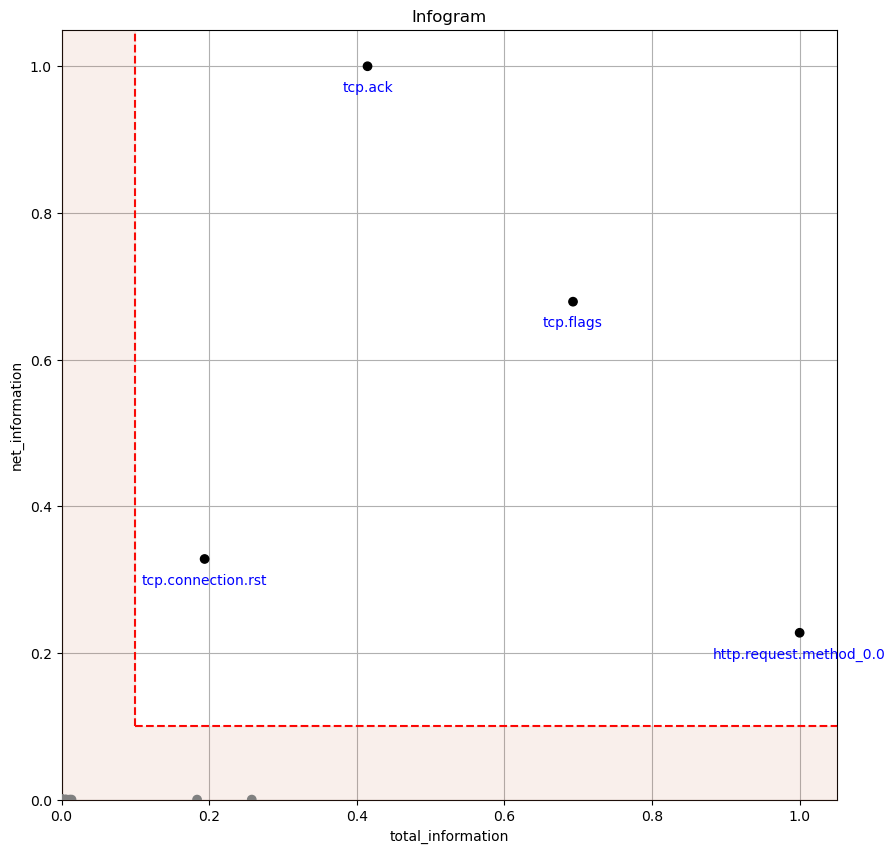

In [13]:
Fea = CSHFeature()
Fea.load(df_data,x_columns = col_x, y_column=col_y,is_regression = False)
ig = Fea.get_inform_graph("AUTO")
ig.plot()

<Axes: >

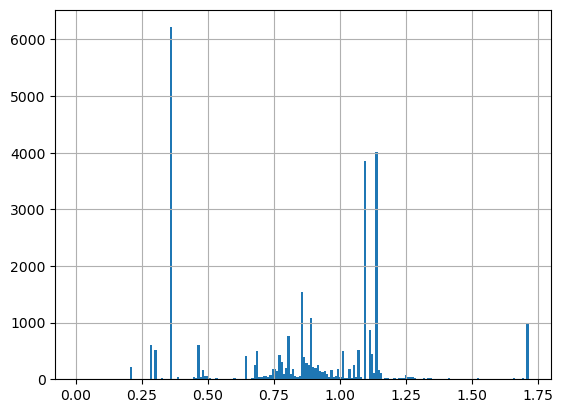

In [14]:
test = df_data['tcp.len']
df_tmp = df_data[(df_data['Attack_label'] == 1) & (df_data['tcp.len'] > 0 )]
test = df_tmp['tcp.len'] + 1
test,l = CSHDataProcess.normal_transform(test)
test.hist(bins=200)

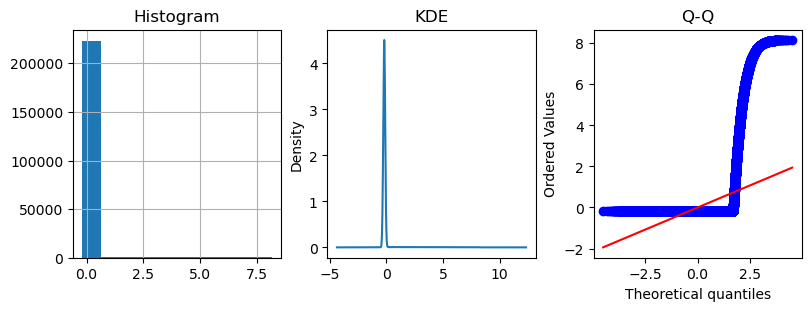

{'shapiro-wilk': {'is_normal': 'False',
  'detail': ShapiroResult(statistic=0.18384838104248047, pvalue=0.0),
  'describe': 'Shapiro-Wilk检验，适用于小样本场合（3≤n≤50），受异常值影响较大。'},
 'kolmogorov-smirnov': {'is_normal': 'False',
  'detail': KstestResult(statistic=0.525556951895521, pvalue=0.0, statistic_location=-0.17688229968444172, statistic_sign=1),
  'describe': 'Kolmogorov-Smirnov检验是一项拟合优度的统计检验。 此测试比较两个分布（在这种情况下，两个分布之一是高斯分布）。 此检验的零假设是，两分布相同（或），两个分布之间没有差异。'},
 'skewness-kurtosis': {'is_normal': 'False',
  'detail': NormaltestResult(statistic=254756.17985712903, pvalue=0.0),
  'describe': 'DAgostino-Pearson方法使用偏度和峰度测试正态性。 该检验的零假设是，分布是从正态分布中得出的。'}}

In [15]:
CSHDataDistribution.show_dist(df_data['tcp.ack'])
CSHDataDistribution.normal_test(df_data['tcp.ack'])

# 划分为训练集和测试集

In [16]:
df_train,df_test = CSHSample.split_dataset(df_data)

# 训练模型和特征重要程度

In [17]:
model = CSHModelClassify()
model.train(df_train,x_columns=col_x,y_column=col_y,train_ratio = 0)
model.importance()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
begin train  dt
dt Model Build progress: |███████████████████████████████████████████████████████| (done) 100%
end train  dt
begin train  svm
psvm Model Build progress: |█████████████████████████████████████████████████████| (done) 100%
end train  svm
begin train  rf
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
end train  rf
begin train  ann
deeplearning Model Build progress: |█████████████████████████████████████████████| (done) 100%
end train  ann
begin train  knn
train knn
end train  knn


,variable,relative_importance,scaled_importance,percentage,model
0,http.request.method_0.0,254413.00000000,1.00000000,0.16260599,rf
1,http.request.method_0,218931.68750000,0.86053656,0.13992840,rf
2,tcp.flags,164372.40625000,0.64608493,0.10505728,rf
3,tcp.len,149998.35937500,0.58958606,0.09587023,rf
4,tcp.ack,138182.62500000,0.54314294,0.08831830,rf
...,...,...,...,...,...
81,http.request.method_0.0.missing(NA),0.00000000,0.00000000,0.00000000,ann
82,http.request.method_GET.missing(NA),0.00000000,0.00000000,0.00000000,ann
83,http.request.method_OPTIONS.missing(NA),0.00000000,0.00000000,0.00000000,ann
84,http.request.method_POST.missing(NA),0.00000000,0.00000000,0.00000000,ann


# 评估模型

In [18]:
model.evaluate(df_test,x_columns=col_x,y_column=col_y)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
dt prediction progress: |████████████████████████████████████████████████████████| (done) 100%
psvm prediction progress: |██████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%


,model,confusion_matrix,recall,mcc,accuracy,precision,auc,f1_score,fbeta_score
0,ann,"[[22594, 633], [385, 22945]]",0.97813433,0.95632169,0.97813433,0.97818809,0.97812244,0.97813345,0.97815957
1,dt,"[[23168, 59], [6032, 17298]]",0.86917112,0.76403968,0.86917112,0.89523747,0.86945432,0.86702070,0.87996399
2,knn,"[[22912, 315], [363, 22967]]",0.98543721,0.97087647,0.98543721,0.98543934,0.98543942,0.98543722,0.98543824
3,rf,"[[23165, 62], [235, 23095]]",0.99362072,0.98726886,0.99362072,0.99364809,0.99362891,0.99362069,0.99363384
4,svm,"[[19075, 4152], [1771, 21559]]",0.87277960,0.74943273,0.87277960,0.87669352,0.87266584,0.87243148,0.87442724


# 将特征进行Normal转换

In [19]:
df_data = CSHSample.resample_smote(df_base,x_columns=col_x,y_column=col_y) 

In [20]:
df_tmp = df_data.copy(deep = True)
scale_colums = []
for key,type in zip(df_tmp.keys(),df_tmp.dtypes):
    if not type in ["bool","object","category"] and not key in [col_y]:
        scale_colums.append(key)

for key in scale_colums:
    df_tmp[key] = (df_tmp[key]-df_tmp[key].min())/(df_tmp[key].max()-df_tmp[key].min()) + 1
    df_tmp[key],l = CSHDataProcess.normal_transform(df_tmp[key])
    
df_train,df_test = CSHSample.split_dataset(df_tmp)

In [21]:
model = CSHModelClassify()
model.train(df_train,x_columns=col_x,y_column=col_y,train_ratio = 0)
model.importance()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
begin train  dt
dt Model Build progress: |███████████████████████████████████████████████████████| (done) 100%
end train  dt
begin train  svm
psvm Model Build progress: |█████████████████████████████████████████████████████| (done) 100%
end train  svm
begin train  rf
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
end train  rf
begin train  ann
deeplearning Model Build progress: |█████████████████████████████████████████████| (done) 100%
end train  ann
begin train  knn
train knn
end train  knn


,variable,relative_importance,scaled_importance,percentage,model
0,http.request.method_0.0,318232.78125000,1.00000000,0.19656431,rf
1,http.request.method_0,215307.12500000,0.67657117,0.13298975,rf
2,tcp.flags,183723.28125000,0.57732356,0.11348121,rf
3,tcp.ack,169190.37500000,0.53165602,0.10450460,rf
4,mqtt.hdrflags,144307.18750000,0.45346424,0.08913489,rf
...,...,...,...,...,...
81,http.request.method_0.0.missing(NA),0.00000000,0.00000000,0.00000000,ann
82,http.request.method_GET.missing(NA),0.00000000,0.00000000,0.00000000,ann
83,http.request.method_OPTIONS.missing(NA),0.00000000,0.00000000,0.00000000,ann
84,http.request.method_POST.missing(NA),0.00000000,0.00000000,0.00000000,ann


In [22]:
model.evaluate(df_test,x_columns=col_x,y_column=col_y)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
dt prediction progress: |████████████████████████████████████████████████████████| (done) 100%
psvm prediction progress: |██████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%


,model,confusion_matrix,recall,mcc,accuracy,precision,auc,f1_score,fbeta_score
0,ann,"[[23128, 49], [357, 23023]]",0.99127951,0.98264570,0.99127951,0.99136602,0.99130819,0.99127938,0.99132095
1,dt,"[[23145, 32], [5844, 17536]]",0.87378912,0.77225180,0.87378912,0.89872793,0.87433105,0.87186298,0.88422282
2,knn,"[[22736, 441], [487, 22893]]",0.98006744,0.96013635,0.98006744,0.98006949,0.98007137,0.98006751,0.98006847
3,rf,"[[23108, 69], [202, 23178]]",0.99417918,0.98837456,0.99417918,0.99419545,0.99419152,0.99417920,0.99418701
4,svm,"[[18962, 4215], [7014, 16366]]",0.75881178,0.52164794,0.75881178,0.76273267,0.75906934,0.75800073,0.76016247


# 调试

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
dt prediction progress: |████████████████████████████████████████████████████████| (done) 100%
psvm prediction progress: |██████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
1 ROC AUC OvR: 0.0746
0 ROC AUC OvR: 0.0748
average ROC AUC OvR: 0.0747


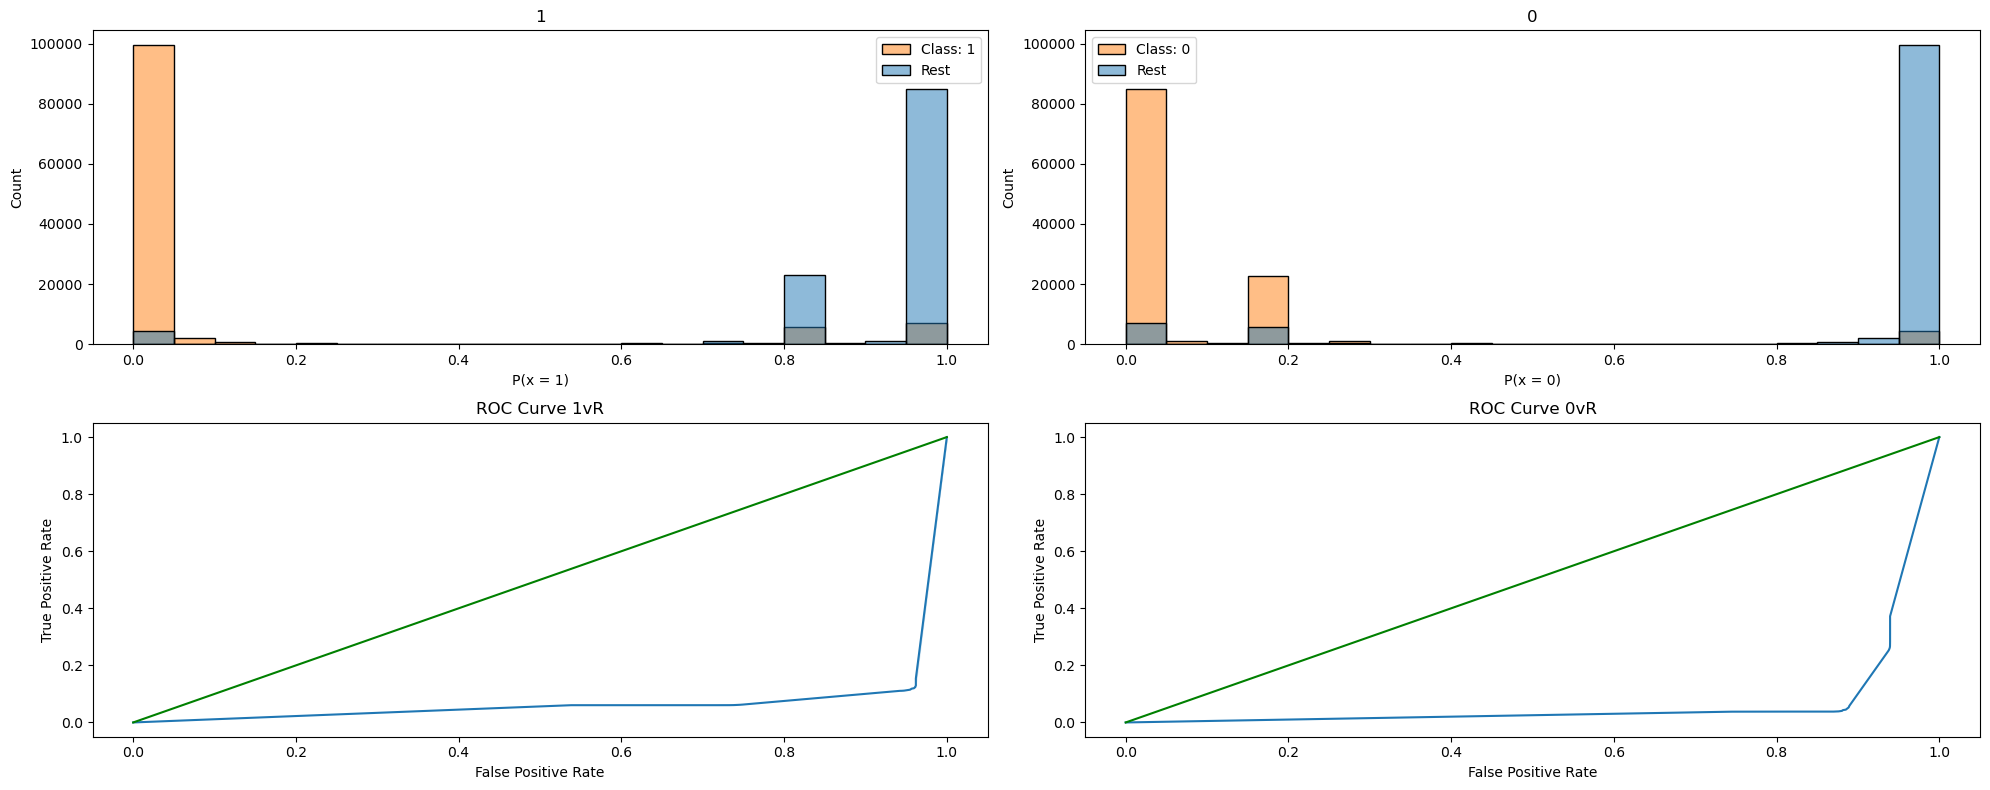

1 vs 0 ROC AUC OvO: 0.0746
0 vs 1 ROC AUC OvO: 0.0748
average ROC AUC OvO: 0.0747


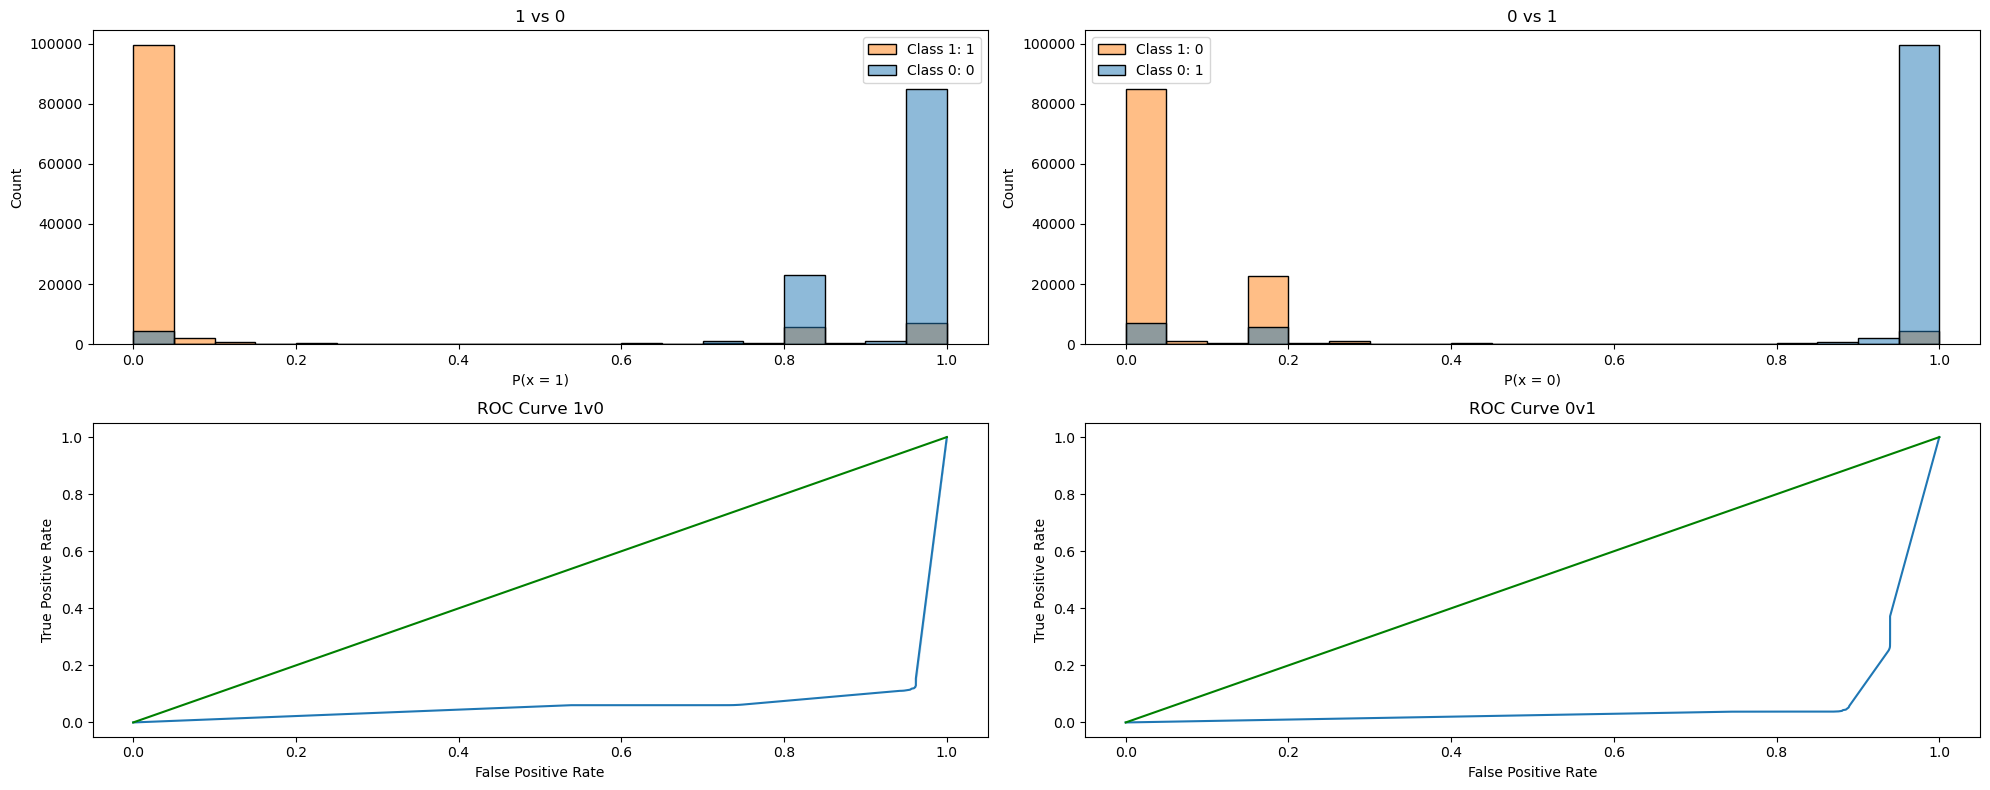

true
1    116900
0    115885
Name: count, dtype: int64

In [23]:
df_pred = model.predict(df_test,x_columns=col_x,y_column=col_y)
roc = CSHROC(df_pred)
roc.show_ROC_by_one_rest(prob_bins=100)
roc.show_ROC_by_one_one(prob_bins=100)
df_pred['true'].value_counts()